##Dynamics I


In [ ]:
!pip install pypoly2tri idealab_tools foldable_robotics pynamics

     |████████████████████████████████| 92kB 4.3MB/s 
     |████████████████████████████████| 1.8MB 13.3MB/s 


## Dynamics Model

![](https://drive.google.com/uc?export=view&id=1foPDHUCwtVs67u7JXOfD_Rw_clGtRGRN)

In [ ]:
%matplotlib inline

In [ ]:
use_constraints = False

In [ ]:
#This block of code imports the necessary modules created by Daniel M. Aukes
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
import pynamics.integration
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi

In [ ]:
#This block of code create a new system object and set that system as the global system within the module so that other variables can use and find it
system = System()
pynamics.set_system(__name__,system)

1. Scale: Ensure your system is using SI units. You should be specifying lengths in meters (so millimeters should be scaled down to the .001 range), forces in Newtons, and radians (not degrees), and masses in kg. You may make educated guesses about mass for now.

In [ ]:
#This block of code declares and store constants
l0 = Constant(0.0254,'l0',system) #defines the lengths (in meters) of each frame (1:1 ratio of paper model)
l1 = Constant(0.0254,'l1',system) #1in ~ 0.0254m
l2 = Constant(0.0508,'l2',system)
l3 = Constant(0.0254,'l3',system)
l4 = Constant(0.0254,'l4',system)
l5 = Constant(0.0508,'l5',system)

mA = Constant(0.01,'mA',system) #defines the mass (in kg) of each frame 
mB = Constant(0.01,'mB',system) #1g ~ 0.001kg
mC = Constant(0.1,'mC',system)
mD = Constant(0.01,'mD',system)
mE = Constant(0.01,'mE',system)
mF = Constant(0.01,'mF',system)

g = Constant(9.81,'g',system) #defines gravity (in m/s^2)
b = Constant(1e-1,'b',system)  #defines damping coefficient (in kg/s^2)
k = Constant(0e-1,'k',system)  #defines spring coefficient (kg/s^2)

preload0 = Constant(135*pi/180,'preload0',system) #defines the spring preload to establish neutral point of frame (radians)
preload1 = Constant(-90*pi/180,'preload1',system)
preload2 = Constant(-45*pi/180,'preload2',system)
preload3 = Constant(45*pi/180,'preload3',system) 
preload4 = Constant(90*pi/180,'preload4',system)
preload5 = Constant(45*pi/180,'preload5',system)

Ixx_A = Constant(1,'Ixx_A',system) #defines the inertia (kg*m^2) of each frame 
Iyy_A = Constant(1,'Iyy_A',system)
Izz_A = Constant(1,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)
Ixx_C = Constant(1,'Ixx_C',system)
Iyy_C = Constant(1,'Iyy_C',system)
Izz_C = Constant(1,'Izz_C',system)
Ixx_D = Constant(1,'Ixx_D',system)  
Iyy_D = Constant(1,'Iyy_D',system)
Izz_D = Constant(1,'Izz_D',system)
Ixx_E = Constant(1,'Ixx_E',system)
Iyy_E = Constant(1,'Iyy_E',system)
Izz_E = Constant(1,'Izz_E',system)
Ixx_F = Constant(1,'Ixx_F',system)
Iyy_F = Constant(1,'Iyy_F',system)
Izz_F = Constant(1,'Izz_F',system)

In [ ]:
#This block of code specifies the precision of the integration 
tol = 1e-12

In [ ]:
#This block of code defines variables for time that can be used throughout the script
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [ ]:
#This block of code creates dynamic state variables for the angles shown in our kinematics model
q0,q0_d,q0_dd = Differentiable('q0',system) #angle between N and A frames
q1,q1_d,q1_dd = Differentiable('q1',system) #angle between A and B frames
q2,q2_d,q2_dd = Differentiable('q2',system) #angle between B and C frames
q3,q3_d,q3_dd = Differentiable('q3',system) #angle between C and D frames
q4,q4_d,q4_dd = Differentiable('q4',system) #angle between D and E frames
q5,q5_d,q5_dd = Differentiable('q5',system) #angle between E and F frames

In [ ]:
#This block of code sets the initial guess for the mechanisms starting position (in radians) and velocity (in m/s)
initialvalues = {}
initialvalues[q0] = 135*pi/180  #optimal angle is 135
initialvalues[q0_d] = 0*pi/180
initialvalues[q1] = -90*pi/180  #optimal angle is -90
initialvalues[q1_d] = 0*pi/180
initialvalues[q2] = -45*pi/180  #optimal angle is -45
initialvalues[q2_d] = 0*pi/180
initialvalues[q3] = 45*pi/180   #optimal angle is 45
initialvalues[q3_d] = 0*pi/180
initialvalues[q4] = 90*pi/180   #optimal angle is 90
initialvalues[q4_d] = 0*pi/180
initialvalues[q5] = 45*pi/180   #optimal angle is 45
initialvalues[q5_d] = 0*pi/180

In [ ]:
#This block of code orders the initial values in a list in such a way that the integrator can use it in the same order that it expects the variables to be supplied
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

In [ ]:
#This block of code initializes frames
N = Frame('N')
A = Frame('A')
B = Frame('B')
C = Frame('C')
D = Frame('D')
E = Frame('E')
F = Frame('F')

In [ ]:
#This block of code sets N frame as the newtonian frame (see kinematic diagram from above)
system.set_newtonian(N) 

In [ ]:
#This block of code shows frame rotation in the Z direction
A.rotate_fixed_axis_directed(N,[0,0,1],q0,system)  #the A frame rotates about the N frame in the Z direction (0,0,1) by q0 degrees
B.rotate_fixed_axis_directed(A,[0,0,1],q1,system)  #the B frame rotates about the A frame in the Z direction (0,0,1) by q1 degrees
C.rotate_fixed_axis_directed(B,[0,0,1],q2,system)  #the C frame rotates about the B frame in the Z direction (0,0,1) by q2 degrees
F.rotate_fixed_axis_directed(N,[0,0,1],q5,system)  #the F frame rotates about the N frame in the Z direction (0,0,1) by q5 degrees
E.rotate_fixed_axis_directed(F,[0,0,1],q4,system)  #the E frame rotates about the F frame in the Z direction (0,0,1) by q4 degrees
D.rotate_fixed_axis_directed(E,[0,0,1],q3,system)  #the D frame rotates about the E frame in the Z direction (0,0,1) by q3 degrees

In [ ]:
#This block of code defines the points needed to create the mechanism 
pNA = 0*N.x + 0*N.y    #pNA (point NA) position is 0 units in the direction of N reference frame's x direction (0*N.x) and y direction (0*N.y)
pAB = pNA + l0*A.x     #pAB position is pNA's position plus l0 units in the direction of ref frame A's x direction 
pBC = pAB + l1*B.x     #pBC position is pAB's position plus l1 units in the direction of ref frame B's x direction
pNF = l5*N.x + 0*N.y   #pNF position l5 units in the direction of ref frame N's x direction and 0 units in N's y direction
pFE = pNF + l4*F.x     #pFE position is pNF's position plus l4 units in the direction of ref frame F's x direction
pED = pFE + l3*E.x     #pED position is pFE's position plus l3 units in the direction of ref frame E's x direction

In [ ]:
#This block of code defines the centers of mass of each link (halfway along the length of each frame)
pAcm=pNA+l0/2*A.x  #pA (link A) position is pNA's position plus one half of l0 units in the direction of ref frame A's x direction
pBcm=pAB+l1/2*B.x  #pB (link B) position is pAB's position plus one half of l1 units in the direction of ref frame B's x direction
pCcm=pBC+l2/2*C.x  #pC (link C) position is pBC's position plus one half of l2 units in the direction of ref frame C's x direction
pDcm=pFE+l3/2*E.x  #pD (link D) position is pFE's position plus one half of l3 units in the direction of ref frame E's x direction
pEcm=pNF+l4/2*B.x  #pE (link E) position is pNF's position plus one half of l4 units in the direction of ref frame F's x direction
pFcm=pNA+l5/2*N.x  #pF (link F) position is pNA's position plus one half of l5 units in the direction of N reference frame's x direction

In [ ]:
#This block of code computes and returns the angular velocity between frames
wNA = N.getw_(A)
wAB = A.getw_(B)
wBC = B.getw_(C)
wNF = N.getw_(F)
wFE = F.getw_(E)
wED = E.getw_(D)

2. Define Inertias: Add a center of mass and a particle or rigid body to each rotational frame. You may use particles for now if you are not sure of the inertial properties of your bodies, but you should plan on finding these values soon for any “payloads” or parts of your system that carry extra loads (other than the weight of paper).

In [ ]:
#This block of code compute the inertia dynamics of each body and defines a rigid body on each frame
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)
ID = Dyadic.build(D,Ixx_D,Iyy_D,Izz_D)
IE = Dyadic.build(E,Ixx_E,Iyy_E,Izz_E)
IF = Dyadic.build(F,Ixx_F,Iyy_F,Izz_F)

BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
#BodyC = Body('BodyC',C,pCcm,mC,IC,system)
BodyC = Particle(pCcm,mC,'ParticleC',system) #here, we represent the mass as a particle located at point pCcm (output frame)
BodyD = Body('BodyD',D,pDcm,mD,ID,system)
BodyE = Body('BodyE',E,pEcm,mE,IE,system)
BodyF = Body('BodyF',F,pFcm,mF,IF,system)

3. Add Forces: Add the acceleration due to gravity. Add rotational springs in the joints (using k=0 is ok for now) and a damper to at least one rotational joint. You do not need to add external motor/spring forces but you should start planning to collect that data.

In [ ]:
#This block of code adds forces and torques to the system with the generic "addforce" method.
#The first parameter supplied is a vector describing the force applied at a point or the torque applied along a given rotational axis. 
#The second parameter is the vector describing the linear speed (for an applied force) or the angular velocity(for an applied torque)
system.addforce(-b*wNA,wNA)
system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)
system.addforce(-b*wNF,wNF)
system.addforce(-b*wFE,wFE)
system.addforce(-b*wED,wED)

In [ ]:
#This block of code adds spring forces
#The first value is the linear spring constant
#The second value is the “stretch” vector, indicating the amount of deflection from the neutral point of the spring.
#The final parameter is the linear or angluar velocity vector (depending on whether your spring is a linear or torsional spring)
system.add_spring_force1(k,(q0-preload0)*N.z,wNA) 
system.add_spring_force1(k,(q1-preload1)*A.z,wAB)
system.add_spring_force1(k,(q2-preload2)*B.z,wBC)
system.add_spring_force1(k,(q3-preload3)*N.z,wNF) 
system.add_spring_force1(k,(q4-preload4)*F.z,wFE)
system.add_spring_force1(k,(q5-preload5)*N.z,wNF)

(<pynamics.force.Force at 0x7f6b015223d0>,
 <pynamics.spring.Spring at 0x7f6b01522610>)

In [ ]:
#This block of code globally applies the force of gravity to all particles and bodies
system.addforcegravity(-g*N.y)

4. Constraints: Keep mechanism constraints in, but follow the pendulum example of double-differentiating all constraint equations.
If you defined your mechanism as unattached to the Newtonian frame, add enough constraints so that it is fully attached to ground (for now). you will be eventually removing these constraints.

In [ ]:
#This block of code defines the closed loop kinematics (vectors) of the sarrus mechanism.
eq_vector = pBC - pED   #vector from pBC to pED
eq_vector1 = pAB - pFE  #vector from pAB to pFE
eq_vector2 = pBC - pNA  #vector from pBC to pNA

In [ ]:
#This block of code defines the systems constraints based on the vectors listed above
eq = [] # eq -> equation

eq.append((eq_vector).dot(N.y))   #constrains pBC and pED to the same Newtonian y-value (horizontal)
eq.append((eq_vector1).dot(N.y))  #constrains pAB and pFE to the same Newtonian y-value (horizontal)
eq.append((eq_vector2).dot(N.x))  #constrains pBC and pNA to the same Newtonian x-value (vertical)

eq_d=[(system.derivative(item)) for item in eq]
eq_dd=[(system.derivative(item)) for item in eq_d]

5. Solution: Add the code from the bottom of the pendulum example for solving for f=ma, integrating, plotting, and animating. Run the code to see your results. It should look similar to the pendulum example with constraints added, as in like a rag-doll or floppy.

In [ ]:
#This block of code calculates the symbolic expression for F and ma
f,ma = system.getdynamics()

2021-03-01 02:37:46,021 - pynamics.system - INFO - getting dynamic equations


In [ ]:
#This block of code solves the system of equations F=ma plus any constraint equations that have been added above. 
#It returns one or two variables. 
#func1 is the function that computes the velocity and acceleration given a certain state.
#lambda1(optional) supplies the function that computes the constraint forces as a function of the resulting states
#The below function inverts the mass matrix numerically every time step.
func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True)

2021-03-01 02:37:46,632 - pynamics.system - INFO - solving a = f/m and creating function
2021-03-01 02:37:46,643 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-03-01 02:37:47,329 - pynamics.system - INFO - done solving a = f/m and creating function
2021-03-01 02:37:47,330 - pynamics.system - INFO - calculating function for lambdas


In [ ]:
#This block of code integrates the function calculated above
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2021-03-01 02:37:47,635 - pynamics.integration - INFO - beginning integration
2021-03-01 02:37:47,640 - pynamics.system - INFO - integration at time 0000.00
2021-03-01 02:37:48,241 - pynamics.system - INFO - integration at time 0006.63
2021-03-01 02:37:48,371 - pynamics.integration - INFO - finished integration


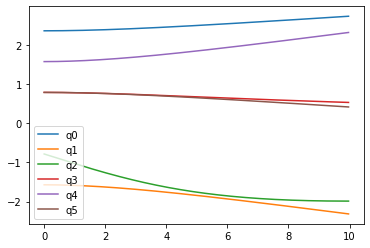

In [ ]:
#This block of code calculates and plots a variety of data from the previous simulation
plt.figure()
artists = plt.plot(t,states[:,:6])
plt.legend(artists,['q0','q1','q2', 'q3', 'q4', 'q5'])

2021-03-01 02:37:48,722 - pynamics.output - INFO - calculating outputs
2021-03-01 02:37:48,741 - pynamics.output - INFO - done calculating outputs


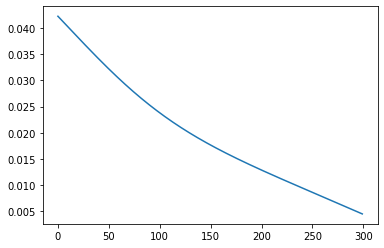

In [ ]:
#This block of code calculates amd plots the energy of system
KE = system.get_KE()
PE = system.getPEGravity(pNA) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states)
energy_output.plot_time()

2021-03-01 02:37:48,967 - pynamics.output - INFO - calculating outputs
2021-03-01 02:37:48,983 - pynamics.output - INFO - done calculating outputs


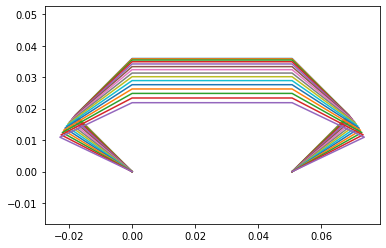

In [ ]:
#This block of code calculates and plots the motion of the system
points = [pNA, pAB, pBC, pED, pFE, pNF]
points_output = PointsOutput(points,system)
y = points_output.calc(states)
points_output.plot_time(20)

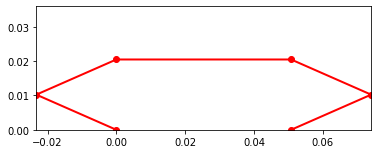

In [ ]:
#This block of code produces a figure of the animations end position using matplotlib
points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

6. **Tuning:** Now adjust the damper value  to something nonzero, that over 10s shows that the system is settling.

In [ ]:
#This block of code animates the figure above
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())

Note: the system behaves like a rag-doll when we set the damper constant to 0. In the video shown above, the system does not behave in such manner because we have set the damper constant to a value greater than 0 in order to satisfy part 6. 